In [781]:
import os
import glob
import math
import json
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

from os import listdir
from os.path import isfile, join
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline
pylab.rcParams['figure.figsize'] = (7.0, 5.0)

### 1. Loading dataset

In [3]:
def show_anns(anns):
    """Display the specified annotations."""
    if len(anns) == 0:
        return 0
    
    ax = plt.gca()
    rectangles = []
    color = []
    for ann in anns:
        c = np.random.random((1,3)).tolist()[0]
        left, bottom, width, height = ann['bbox']
        rectangles.append(Rectangle([left, bottom], width, height, alpha=0.4))
        color.append(c)
        if 'word' in ann.keys():
            ax.annotate(ann['word'], xy=(left,bottom + height), color=c)
    
    p = PatchCollection(rectangles, facecolors=color, edgecolors=(0,0,0,1),
                       linewidths=3, alpha=0.4)
    ax.add_collection(p)
    
# def gt_parser(gt_str):
    

In [4]:
IMGS_DIR = "/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/Challenge2_Training_Task12_Images"
GT_DIR = "/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/Challenge2_Training_Task1_GT"

In [5]:
imgs = glob.glob(join(IMGS_DIR, "*.jpg"))
gts = glob.glob(join(GT_DIR, "*.txt"))
imgs.sort()
gts.sort()

dataset = []
for img, gt in zip(imgs, gts):
    sample = {}
    sample["img"] = img
    
    anns = []
    with open(gt) as f:
        for line in f:
            left, top, right, bottom, word = line.rstrip('\r\n').split(" ")
            left = int(left); top = int(top); 
            right = int(right); bottom = int(bottom)
            width = right - left
            height = top - bottom
            
            word = word.replace("\"", "").lower()
            ann = {"bbox": (left, bottom, width, height),
                  "word": word}
            anns.append(ann)
            
    sample["anns"] = anns
    
    dataset.append(sample)

/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/Challenge2_Training_Task12_Images/287.jpg


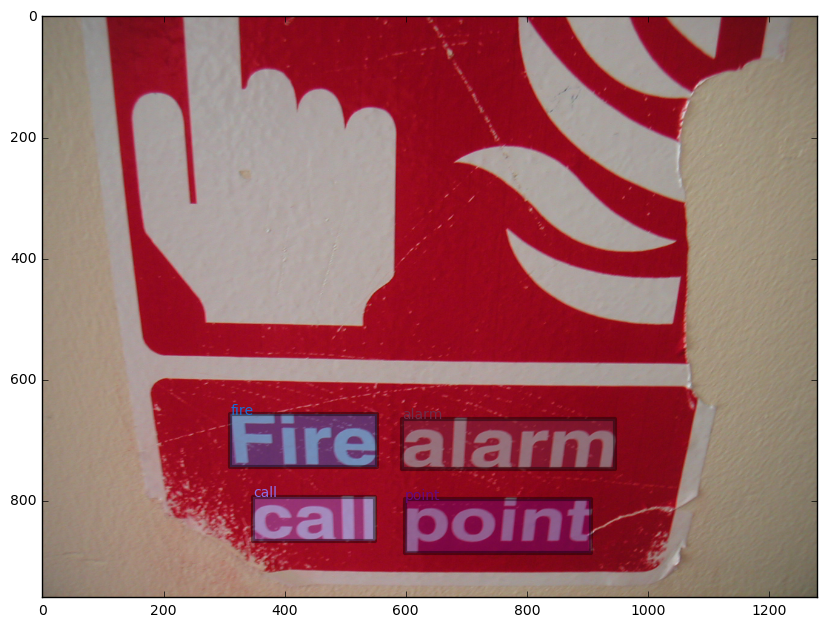

In [142]:
sample_id = random.randint(0, len(dataset)-1)
I = io.imread(dataset[sample_id]['img'])
print dataset[sample_id]['img']
plt.figure()
plt.imshow(I)
show_anns(dataset[sample_id]['anns'])

### 2. Vertical anchors

In [108]:
class AnchorText:
    def __init__(self):
        self.anchor_num=10

    def generate_basic_anchors(self, sizes, base_size=16):
        """
        :param sizes: [(h1, w1), (h2, w2)...]
        :param base_size
        :return:
        """
        assert(self.anchor_num==len(sizes))
        base_anchor=np.array([0, 0, base_size-1, base_size-1], np.int32)
        anchors=np.zeros((len(sizes), 4), np.int32)
        index=0
        for h, w in sizes:
            anchors[index]=self.scale_anchor(base_anchor, h, w)
            index+=1
        return anchors

    def scale_anchor(self, anchor, h, w):
        x_ctr=(anchor[0]+anchor[2])*0.5
        y_ctr=(anchor[1]+anchor[3])*0.5
        scaled_anchor=anchor.copy()
        scaled_anchor[0]=x_ctr-w/2
        scaled_anchor[2]=x_ctr+w/2
        scaled_anchor[1]=y_ctr-h/2
        scaled_anchor[3]=y_ctr+h/2
        return scaled_anchor

    def apply_deltas_to_anchors(self, boxes_delta, anchors):
        """
            :return [l t r b]
        """
        anchor_y_ctr=(anchors[:, 1]+anchors[:, 3])/2.
        anchor_h=anchors[:, 3]-anchors[:, 1]+1.
        global_coords=np.zeros_like(boxes_delta, np.float32)
        global_coords[:, 1]=np.exp(boxes_delta[:, 1])*anchor_h
        global_coords[:, 0]=boxes_delta[:, 0]*anchor_h+anchor_y_ctr-global_coords[:, 1]/2.
        return np.hstack((anchors[:, [0]], global_coords[:, [0]], anchors[:, [2]],
                          global_coords[:, [0]]+global_coords[:, [1]])).astype(np.float32)

    def basic_anchors(self):
        """
            anchor [l t r b]
        """
        heights=[11, 16, 23, 33, 48, 68, 97, 139, 198, 283]
        widths=[16]
        sizes=[]
        for h in heights:
            for w in widths:
                sizes.append((h, w))
        return self.generate_basic_anchors(sizes)

    def locate_anchors(self, feat_map_size, feat_stride):
        """
            return all anchors on the feature map
        """
        basic_anchors_=self.basic_anchors()
        anchors=np.zeros((basic_anchors_.shape[0]*feat_map_size[0]*feat_map_size[1], 4), np.int32)
        index=0
        for y_ in range(feat_map_size[0]):
            for x_ in range(feat_map_size[1]):
#                 print y_, x_
                shift=np.array([x_, y_, x_, y_])*feat_stride
                anchors[index:index+basic_anchors_.shape[0], :]=basic_anchors_+shift
                index+=basic_anchors_.shape[0]
        return anchors

In [408]:
def show_anchors(anchors):
    """Display the anchors."""
    if len(anchors) == 0:
        return 0
    
    ax = plt.gca()
    rectangles = []
    for anchor in anchors:
        c = np.random.random((1,3)).tolist()[0]
        left, top, right, bottom = anchor
        width = right - left;
        height = top - bottom
        rectangles.append(Rectangle([left, bottom], width, height, alpha=0.4))
    
    p = PatchCollection(rectangles, edgecolors='red',
                       linewidths=1, alpha=0.4)
    ax.add_collection(p)
    
def threshold(coords, min_, max_):
    return np.maximum(np.minimum(coords, max_), min_)
    
def clip_boxes(boxes, im_shape):
    """
    Clip boxes to image boundaries.
    """
    boxes[:, 0::2]=threshold(boxes[:, 0::2], 0, im_shape[1]-1)
    boxes[:, 1::2]=threshold(boxes[:, 1::2], 0, im_shape[0]-1)
    return boxes

In [784]:
def get_valid_anchors(anchors, im_width, im_height, allowed_border):
    # l, t, r, b
    valid_indices = np.where(
        (anchors[:, 0] >= -allowed_border) &
        (anchors[:, 1] >= -allowed_border) &
        (anchors[:, 2] < im_width + allowed_border) &
        (anchors[:, 3] < im_height + allowed_border)
    )[0]
    
    return valid_indices

def divide_gt_bboxes(gt_bboxes):
    anchors_list = []
    for left, top, right, bottom in gt_bboxes:
        anchor_ids = np.arange(int(math.floor(1.*left / shift)),
                             int(math.ceil(1.*right / shift)))
        anchors = np.zeros((len(anchor_ids), 4))
        anchors[:, [1,3]] = (top, bottom)
        anchors[:, 0] = anchor_ids * shift
        anchors[:, 2] = (anchor_ids+1) * shift
        anchors_list.append(anchors)

    gt_anchors = np.concatenate(anchors_list, axis=0)
    return gt_anchors

def label_anchors(anchors, gt_anchors, threshold=0.7):
    # Array containing the label for each anchor
    cls_anchors = np.zeros((anchors.shape[0]), dtype=np.int)
    
    # Calculate the IoU between the anchors and the ground truth anchors
    overlaps = bbox_overlaps(
        np.ascontiguousarray(anchors, dtype=np.float),
        np.ascontiguousarray(gt_anchors, dtype=np.float))
    
    # Labeling anchors
    # ii. The anchors with the highest IoU overlap with GT boxes.
    highest_argmax_overlaps = overlaps.argmax(axis=0)
    cls_anchors[highest_argmax_overlaps] = 1
    highest_argmax_overlaps = np.array([highest_argmax_overlaps,
                                       np.arange(len(highest_argmax_overlaps))])
    
    # i. Anchors that have > threhsold IoU overlap with any GT box
    valid_argmax_overlaps = np.where(overlaps > threshold)
    cls_anchors[valid_argmax_overlaps[0]] = 1
    
    # TODO: Use zero initialization instead of valid_argmax_overlaps
    mask = np.in1d(highest_argmax_overlaps[0], valid_argmax_overlaps[0])
    new_anchors_id = np.where(~mask)[0]
    if len(np.where(~mask)[0]) > 0:
        pos_anchors = (np.append(valid_argmax_overlaps[0],
                                   highest_argmax_overlaps[0][new_anchors_id]),
                        np.append(valid_argmax_overlaps[1],
                                  highest_argmax_overlaps[1][new_anchors_id]))
    else:
        pos_anchors = valid_argmax_overlaps
    
    return cls_anchors, pos_anchors

In [763]:
def calculate_gt_coordinates(anchors, gt_anchors):
    # Get the positive anchors
    cls_anchors_1, pos_anchors_1 = label_anchors(anchors, gt_anchors, threshold=0.7)

    # Get the anchors having IoU > 0.5 overlap with a ground truth proposal
    cls_anchors_2, pos_anchors_2 = label_anchors(anchors, gt_anchors, threshold=0.5)

    mask = np.in1d(pos_anchors_1[0], pos_anchors_2[0])
    new_anchors_id = np.where(~mask)[0]
    if len(np.where(~mask)[0]) > 0:
        pos_anchors = (np.append(pos_anchors_1[0],
                                   pos_anchors_2[0][new_anchors_id]),
                        np.append(pos_anchors_1[1],
                                  pos_anchors_2[1][new_anchors_id]))
    else:
        pos_anchors = pos_anchors_1

    num_pos_anchors = len(pos_anchors[0])
    valid_anchors = np.zeros((num_pos_anchors, 4))
    valid_coords = np.zeros((num_pos_anchors, 2))

    gt_valid_anchors = gt_anchors[pos_anchors[1]]
    height = gt_valid_anchors[:, 3] - gt_valid_anchors[:, 1]
    center = gt_valid_anchors[:, 1] + height / 2.
    valid_anchors = anchors[pos_anchors[0]]
    valid_coords = np.stack((height, center), axis=-1)
    
    print pos_anchors[0], valid_anchors, valid_coords

In [1066]:
def compute_vertical_overlap(anchors, gt_anchors):
    N = anchors.shape[0]
    K = gt_anchors.shape[0]
    overlaps = np.zeros((N, K))
    for n in range(N):
        overlap_heights = np.maximum(
            (np.minimum(anchors[n, 3], gt_anchors[:, 3]) -
             np.maximum(anchors[n, 1], gt_anchors[:, 1])),
            0)
        total_heights = np.maximum(anchors[n, 3], gt_anchors[:, 3]) - \
                        np.minimum(anchors[n, 1], gt_anchors[:, 1])
        overlaps[n, :] = overlap_heights / total_heights
    return overlaps

def calculate_offsets(anchors, gt_bboxes,
                      ver_threshold=0.5,
                      hor_threshold=32):
    vertical_overlaps = compute_vertical_overlap(anchors, gt_bboxes)
    ver_anchors_ids, bbox_ids = np.where(vertical_overlaps > ver_threshold)
    ver_anchors = anchors[ver_anchors_ids, :]

    side_anchors_ids = []
    for i, gt_bbox in enumerate(gt_bboxes):
        pos_mask = np.where(bbox_ids == i)[0]
        centers = ver_anchors[:, 0] + (ver_anchors[:, 2] - ver_anchors[:, 0]) / 2.
        left_ids = np.where(np.absolute(centers - gt_bbox[0]) < hor_threshold)[0]
        right_ids = np.where(np.absolute(centers - gt_bbox[2]) < hor_threshold)[0]
        left_ids = np.intersect1d(pos_mask, left_ids).tolist()
        right_ids = np.intersect1d(pos_mask, right_ids).tolist()
        side_anchors_ids.extend(left_ids)
        side_anchors_ids.extend(right_ids)

    side_anchors_ids = list(set(side_anchors_ids))

    offsets = []
    for i in side_anchors_ids:
        center = ver_anchors[i, 0] + (ver_anchors[i, 2] - ver_anchors[i, 0]) / 2.
        off_id = np.argmin(np.minimum(np.absolute(center - gt_bboxes[:, 0]),
                                      np.absolute(center - gt_bboxes[:, 2])))
        if abs(center - gt_bboxes[off_id, 0]) > abs(center - gt_bboxes[off_id, 2]):
            offset = gt_bboxes[off_id, 0]
        else:
            offset = gt_bboxes[off_id, 2]

        offsets.append(offset)
        
    side_anchors = ver_anchors[side_anchors_ids, :]
    
    return side_anchors, offsets

In [109]:
anchor_generator = AnchorText()

/home/ubuntu/tbhien/ref_smart_bookcase/dataset/icdar_2013/Challenge2_Training_Task12_Images/106.jpg


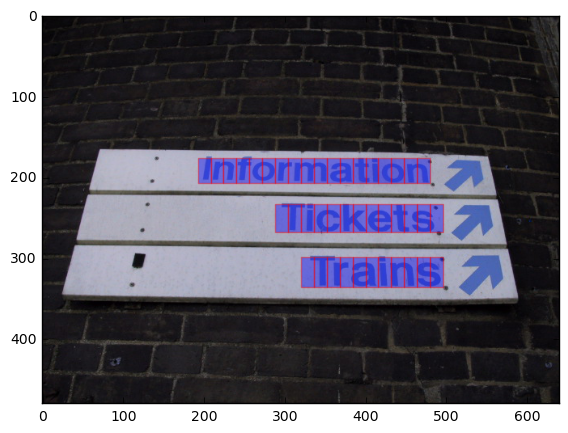

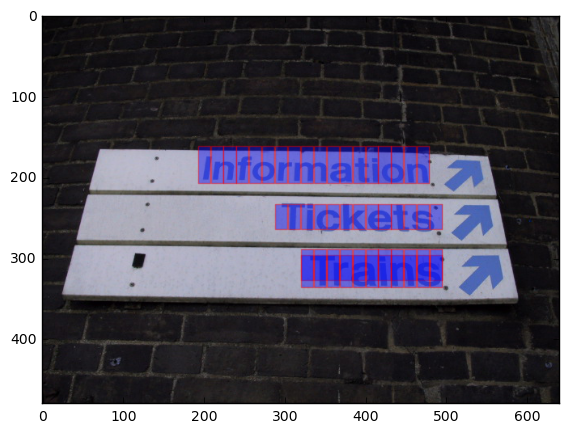

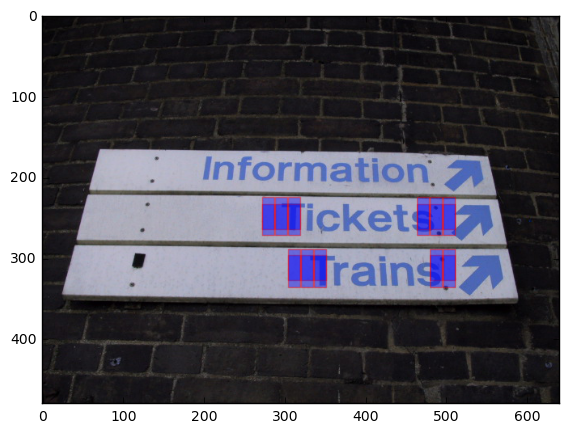

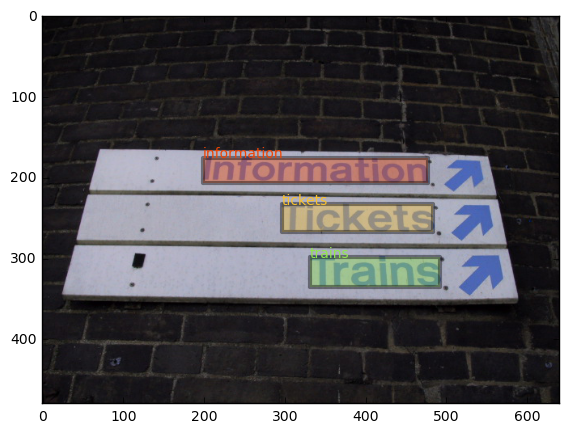

In [1073]:
sample_id = random.randint(0, len(dataset)-1)
I = io.imread(dataset[sample_id]['img'])
print dataset[sample_id]['img']

im_w, im_h = I.shape[:2]
feat_map_size = [int(math.ceil(im_w / 16.)),
                 int(math.ceil(im_h / 16.))]
anchors = anchor_generator.locate_anchors(feat_map_size, 16)

anns = dataset[sample_id]['anns']

gt_bboxes = np.zeros((len(anns), 4))
for i, ann in enumerate(anns):
    left, bottom, width, height = ann['bbox']
    top = bottom + height
    right = left + width
    gt_bboxes[i, :] = [left, top, right, bottom]
    
gt_anchors = divide_gt_bboxes(gt_bboxes)
cls_anchors, _ = label_anchors(anchors, gt_anchors, threshold=0.7)

positive_anchors = anchors[np.where(cls_anchors == 1), :]
positive_anchors = positive_anchors.reshape(positive_anchors.shape[1:])

side_anchors, offsets = calculate_offsets(anchors, gt_bboxes, 0.7, 20)

plt.figure()
plt.imshow(I)
show_anchors(gt_anchors)

plt.figure()
plt.imshow(I)
show_anchors(positive_anchors)

plt.figure()
plt.imshow(I)
show_anchors(side_anchors)

plt.figure()
plt.imshow(I)
show_anns(dataset[sample_id]['anns'])

In [1]:
class AnchorLabeller:

    def __init__(num_anchors=10, shift=16.0, offset_dist_threshold=20.,
                 positive_threshold=0.7, negative_threshold=0.5,
                 coord_overlap_threshold=0.5, ver_overlap_threshold=0.5):
        self.num_anchors = num_anchors
        self.shift = shift
        self.offset_dist_threshold = offset_dist_threshold
        self.positive_threshold = positive_threshold
        self.negative_threshold = negative_threshold
        self.coord_overlap_threshold = coord_overlap_threshold
        self.ver_overlap_threshold = ver_overlap_threshold

        self.anchor_generator = AnchorText()


    def generate_anchors(self, img_width, img_height, gt_bboxes):
        feat_map_size = [int(math.ceil(img_width / self.shift)),
                     int(math.ceil(img_height / self.shift))]
        anchors = self.anchor_generator.locate_anchors(feat_map_size, 16)
        gt_anchors = self.divide_gt_bboxes(gt_bboxes)
        cls_anchors, _ = self.label_anchors(anchors, gt_anchors, threshold=0.7)
        coord_ids, coords = self.calculate_gt_coordinates(anchors, gt_anchors)
        side_ids, offsets = self.calculate_offsets(anchors, gt_bboxes,
                                                   self.ver_overlap_threshold,
                                                   self.offset_dist_threshold)
        data = {
            "anchors": anchors,
            "classes": cls_anchors,
            "coord_ids": coor_ids,
            "coords": coords,
            "side_ids": side_ids,
            "offsets": offsets
        }

        return data


    def divide_gt_bboxes(self, gt_bboxes, shift=16.):
        anchors_list = []
        for left, top, right, bottom in gt_bboxes:
            anchor_ids = np.arange(int(math.floor(1.*left / shift)),
                                 int(math.ceil(1.*right / shift)))
            anchors = np.zeros((len(anchor_ids), 4))
            anchors[:, [1,3]] = (top, bottom)
            anchors[:, 0] = anchor_ids * shift
            anchors[:, 2] = (anchor_ids+1) * shift
            anchors_list.append(anchors)

        gt_anchors = np.concatenate(anchors_list, axis=0)
        return gt_anchors


    def label_anchors(self, anchors, gt_anchors, threshold=0.7):
        # Array containing the label for each anchor
        cls_anchors = np.zeros((anchors.shape[0]), dtype=np.int)

        # Calculate the IoU between the anchors and the ground truth anchors
        overlaps = bbox_overlaps(
            np.ascontiguousarray(anchors, dtype=np.float),
            np.ascontiguousarray(gt_anchors, dtype=np.float))

        # Labeling anchors
        # ii. The anchors with the highest IoU overlap with GT boxes.
        highest_argmax_overlaps = overlaps.argmax(axis=0)
        cls_anchors[highest_argmax_overlaps] = 1
        highest_argmax_overlaps = np.array([highest_argmax_overlaps,
                                           np.arange(len(highest_argmax_overlaps))])

        # i. Anchors that have > threhsold IoU overlap with any GT box
        valid_argmax_overlaps = np.where(overlaps > threshold)
        cls_anchors[valid_argmax_overlaps[0]] = 1

        # TODO: Use zero initialization instead of valid_argmax_overlaps
        mask = np.in1d(highest_argmax_overlaps[0], valid_argmax_overlaps[0])
        new_anchors_id = np.where(~mask)[0]
        if len(np.where(~mask)[0]) > 0:
            pos_anchors = (np.append(valid_argmax_overlaps[0],
                                       highest_argmax_overlaps[0][new_anchors_id]),
                            np.append(valid_argmax_overlaps[1],
                                      highest_argmax_overlaps[1][new_anchors_id]))
        else:
            pos_anchors = valid_argmax_overlaps

        return cls_anchors, pos_anchors


    def calculate_gt_coordinates(self, anchors, gt_anchors):
        # Get the positive anchors
        cls_anchors_1, pos_anchors_1 = self.label_anchors(anchors, gt_anchors,
                                                          threshold=0.7)

        # Get the anchors having IoU > 0.5 overlap with a ground truth proposal
        cls_anchors_2, pos_anchors_2 = self.label_anchors(anchors, gt_anchors,
                                                          threshold=0.5)

        mask = np.in1d(pos_anchors_1[0], pos_anchors_2[0])
        new_anchors_id = np.where(~mask)[0]
        if len(np.where(~mask)[0]) > 0:
            pos_anchors = (np.append(pos_anchors_1[0],
                                       pos_anchors_2[0][new_anchors_id]),
                            np.append(pos_anchors_1[1],
                                      pos_anchors_2[1][new_anchors_id]))
        else:
            pos_anchors = pos_anchors_1

        num_pos_anchors = len(pos_anchors[0])
        valid_coords = np.zeros((num_pos_anchors, 2))

        gt_valid_anchors = gt_anchors[pos_anchors[1]]
        height = gt_valid_anchors[:, 3] - gt_valid_anchors[:, 1]
        center = gt_valid_anchors[:, 1] + height / 2.
        valid_coords = np.stack((height, center), axis=-1)

        return pos_anchors[0], valid_coords


    def compute_vertical_overlap(self, anchors, gt_anchors):
        N = anchors.shape[0]
        K = gt_anchors.shape[0]
        overlaps = np.zeros((N, K))
        for n in range(N):
            overlap_heights = np.maximum(
                (np.minimum(anchors[n, 3], gt_anchors[:, 3]) -
                 np.maximum(anchors[n, 1], gt_anchors[:, 1])),
                0)
            total_heights = np.maximum(anchors[n, 3], gt_anchors[:, 3]) - \
                            np.minimum(anchors[n, 1], gt_anchors[:, 1])
            overlaps[n, :] = overlap_heights / total_heights
        return overlaps


    def calculate_offsets(anchors, gt_bboxes, ver_threshold=0.5,
                          hor_threshold=32):
        vertical_overlaps = self.compute_vertical_overlap(anchors, gt_bboxes)
        ver_anchors_ids, bbox_ids = np.where(vertical_overlaps > ver_threshold)
        ver_anchors = anchors[ver_anchors_ids, :]

        side_anchors_ids = []
        for i, gt_bbox in enumerate(gt_bboxes):
            pos_mask = np.where(bbox_ids == i)[0]
            centers = ver_anchors[:, 0] + (ver_anchors[:, 2] - \
                                           ver_anchors[:, 0]) / 2.
            left_ids = np.where(np.absolute(centers - gt_bbox[0]) < \
                                hor_threshold)[0]
            right_ids = np.where(np.absolute(centers - gt_bbox[2]) < \
                                 hor_threshold)[0]
            left_ids = np.intersect1d(pos_mask, left_ids).tolist()
            right_ids = np.intersect1d(pos_mask, right_ids).tolist()
            side_anchors_ids.extend(left_ids)
            side_anchors_ids.extend(right_ids)

        side_anchors_ids = list(set(side_anchors_ids))

        offsets = []
        for i in side_anchors_ids:
            center = ver_anchors[i, 0] + (ver_anchors[i, 2] - \
                                          ver_anchors[i, 0]) / 2.
            off_id = np.argmin(np.minimum(np.absolute(center - gt_bboxes[:, 0]),
                                          np.absolute(center - gt_bboxes[:, 2])))
            if (abs(center - gt_bboxes[off_id, 0]) >
                abs(center - gt_bboxes[off_id, 2])):
                offset = gt_bboxes[off_id, 0]
            else:
                offset = gt_bboxes[off_id, 2]

            offsets.append(offset)

        side_anchors_ids = ver_anchors_ids[side_anchors_ids]

        return side_anchors_ids, offsets